# Vluchtenanalyse
In dit Jupyter Notebook ga je een dataset van vluchten opschonen, en ontbrekende gegevens aanvullen in een dataset van luchthavens. Later in het level ga je deze datasets linken en plotten op een kaart.

## 1. Data inlezen
Lees de aangeleverde data in met pandas. Krijg een indruk van de data door de head te bekijken en het aantal datapunten te printen.

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import matplotlib.lines as mlines


We beginnen met het bestand `flights_usa.csv`.

In [2]:
df_flights = pd.read_csv('flights_usa.csv')
df_airports = pd.read_csv('airports_usa.csv')

## 2. Data cleaning

De datasets bevatten momenteel gebrekkige data waar je niet mee kunt werken. Dus ga je ontbrekende gegevens aanvullen, en incomplete data verwijderen.

### Checken op ontbrekende waardes in de kolom DESTINATION_AIRPORT:

In [3]:
missing_values = df_flights['DESTINATION_AIRPORT'].isnull().sum()
print("Aantal ontbrekende waardes in DESTINATION_AIRPORT:", missing_values)

Aantal ontbrekende waardes in DESTINATION_AIRPORT: 4723


### Printen van het percentage ontbrekende aankomstvliegvelden:

In [4]:
total_rows = len(df_flights)
percentage_missing = (missing_values / total_rows) * 100
print("Percentage ontbrekende aankomstvliegvelden:", percentage_missing, "%")

Percentage ontbrekende aankomstvliegvelden: 4.2141047146579105 %


### Verwijderen van rijen waar DESTINATION_AIRPORT NaN is:

In [5]:
df_flights = df_flights.dropna(subset=['DESTINATION_AIRPORT'])

### Verwijderen van gecancelde vluchten:

In [6]:
df_flights = df_flights[df_flights['CANCELLED'] == 0]

### Printen van het aantal overgebleven datapunten:

In [7]:
remaining_data_points = len(df_flights)
print("Aantal overgebleven datapunten:", remaining_data_points)

Aantal overgebleven datapunten: 105621


### Detecteer voor welke vliegvelden het latitude- of longitude-coördinaat ontbreekt.

In [8]:
missing_coords = df_airports[df_airports['LATITUDE'].isnull() | df_airports['LONGITUDE'].isnull()]
print(missing_coords)

    IATA_CODE                              AIRPORT           CITY STATE  \
276       SFO  San Francisco International Airport  San Francisco    CA   

    COUNTRY  LATITUDE  LONGITUDE  
276     USA       NaN        NaN  


### SFO ontbreekt coördinaten. Vul deze aan met de coördinaten van Google.

In [9]:
sfo_row = df_airports[df_airports['IATA_CODE'] == 'SFO']
if not sfo_row.empty:
    new_latitude = 37.615223
    new_longitude = -122.389977

    df_airports.at[sfo_row.index[0], 'LATITUDE'] = new_latitude
    df_airports.at[sfo_row.index[0], 'LONGITUDE'] = new_longitude

    print(df_airports.loc[sfo_row.index])
else:
    print("Rij met IATA_CODE 'SFO' niet gevonden.")

    IATA_CODE                              AIRPORT           CITY STATE  \
276       SFO  San Francisco International Airport  San Francisco    CA   

    COUNTRY   LATITUDE   LONGITUDE  
276     USA  37.615223 -122.389977  


## 3. Data linken

Exercise 3: combineer de twee datasets.

### Bereken het aantal gelande vluchten per aankomstvliegveld

In [10]:
arriving_flights_counts = df_flights['DESTINATION_AIRPORT'].value_counts()

### Voeg de 'ARRIVING FLIGHTS' kolom toe aan het vliegvelden dataframe

In [11]:
df_airports['ARRIVING FLIGHTS'] = df_airports['IATA_CODE'].map(arriving_flights_counts)

### Filter alleen vliegvelden die in het vluchten dataframe voorkomen

In [12]:
df_airports = df_airports[df_airports['IATA_CODE'].isin(arriving_flights_counts.index)]

### Toon het aangepaste vliegvelden dataframe

In [13]:
print(df_airports)

    IATA_CODE                                            AIRPORT  \
20        ATL   Hartsfield-Jackson Atlanta International Airport   
22        AUS             Austin-Bergstrom International Airport   
27        BET                                     Bethel Airport   
38        BOI                 Boise Airport (Boise Air Terminal)   
39        BOS   Gen. Edward Lawrence Logan International Airport   
85        DEN                       Denver International Airport   
140       HNL                     Honolulu International Airport   
165       JFK  John F. Kennedy International Airport (New Yor...   
173       LAS                     McCarran International Airport   
181       LGA            LaGuardia Airport (Marine Air Terminal)   
194       MDW               Chicago Midway International Airport   
202       MIA                        Miami International Airport   
215       MSP       Minneapolis-Saint Paul International Airport   
216       MSY  Louis Armstrong New Orleans Inter

## 4. Visualiseren op de kaart
Exercise 4: gebruik geopandas en seaborn om de gecombineerde data te plotten op een kaart.

/var/folders/rp/9jyh90jj3qsdsyd1nkc4cdyw0000gn/T/ipykernel_22333/1026145745.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


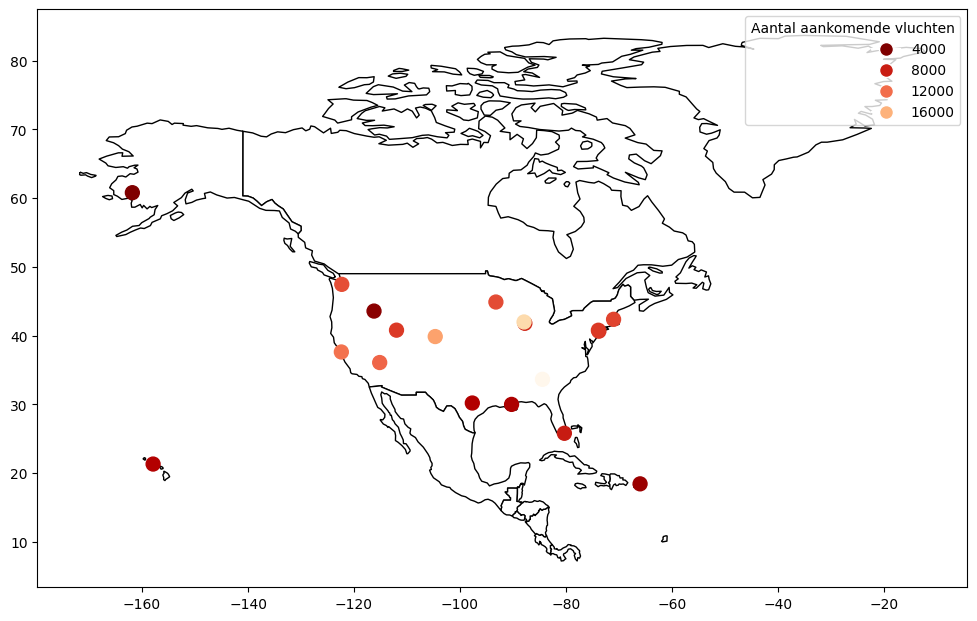

In [27]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

f, ax = plt.subplots(1, figsize=(12, 12))

ax = world[world.continent == 'North America'].plot(
    color='white', edgecolor='black', ax=ax)

# Assuming you have already created df_airports somewhere in your code
gdf_airports = gpd.GeoDataFrame(
    df_airports,
    geometry=gpd.points_from_xy(df_airports.LONGITUDE, df_airports.LATITUDE),
    crs="EPSG:4326"
)

# Plot airport locations colored by the number of arriving flights
gdf_airports.plot(
    ax=ax,
    markersize=100,
    column='ARRIVING FLIGHTS',
    legend=False,
    cmap="OrRd_r"
)

colors = plt.cm.OrRd_r([0, 0.2, 0.4, 0.6, 0.8, 1])
labels = [
    '4000',
    '8000',
    '12000',
    '16000'
]

legend_handles = [mlines.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for
                  color, label in zip(colors, labels)]

leg = ax.legend(handles=legend_handles, loc='upper right', title="Aantal aankomende vluchten")
leg._legend_box.align = "right"

plt.show()
